In [1]:
import os

import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import altair as alt

In [2]:
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [3]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

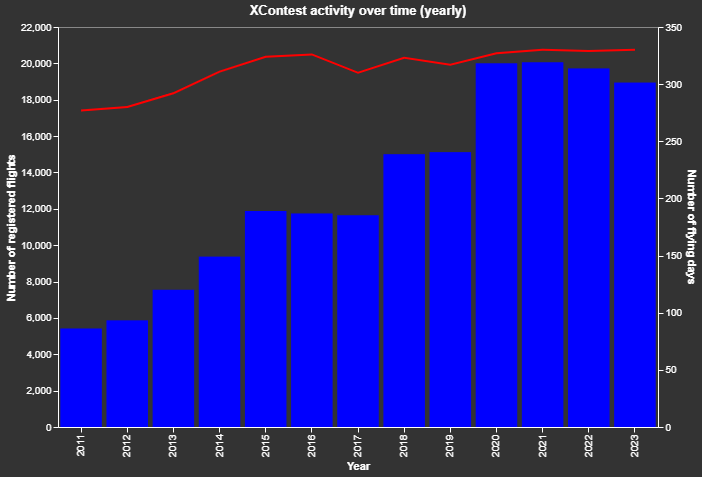

In [4]:
query = """
WITH flights AS (
    SELECT
        *,
        DATE_PART('year', date) AS year
    FROM source.flights
)
SELECT
    year,
    COUNT(*) AS total_flights,
    COUNT(DISTINCT date) AS flying_days
FROM flights
WHERE year < 2024
GROUP BY year
ORDER BY year
"""
df = pd.read_sql(query, engine)
base = alt.Chart(df).encode(
    x=alt.X('year:N', axis=alt.Axis(title='Year')),
    tooltip=['year:N', 'total_flights:Q', 'flying_days:Q']
)
bar = base.mark_bar(color='blue').encode(
    y=alt.Y('total_flights:Q', axis=alt.Axis(title='Number of registered flights'))
)
line1 = base.mark_line(color='red').encode(
    y=alt.Y('flying_days:Q', axis=alt.Axis(title='Number of flying days')),
).transform_calculate(
    var2='datum.flying_days'
)
combined = alt.layer(bar, line1).resolve_scale(
    y='independent'
).properties(
    width=600,
    height=400,
    title="XContest activity over time (yearly)"
)
combined.show()

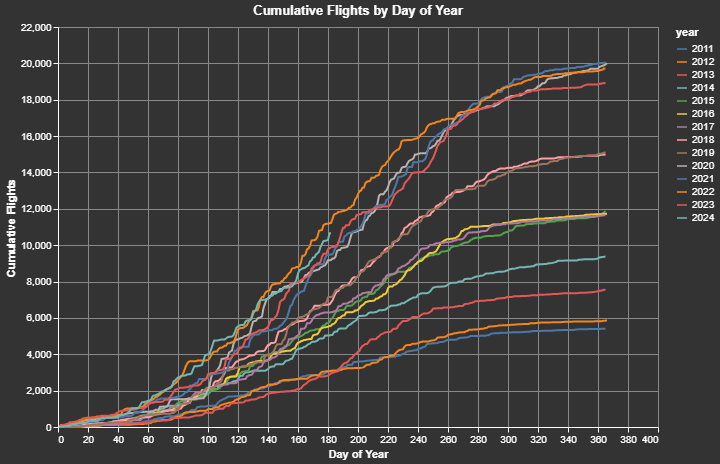

In [5]:
query = """
WITH calendar AS (
    SELECT GENERATE_SERIES('2011-01-01'::date, '2024-06-30'::date, '1 day') AS date
),
daily_flights AS (
    SELECT
        date,
        DATE_PART('year', date) AS year,
        count(*) AS total_flights
    FROM source.flights
    GROUP BY date
),
all_days AS (
    SELECT
        c.date,
        EXTRACT(DOY FROM c.date) AS day_of_year,
        DATE_PART('year', c.date) AS year,
        COALESCE(total_flights, 0) AS total_flights
    FROM calendar c
    LEFT JOIN daily_flights df
        ON c.date = df.date
)
SELECT
    year,
    day_of_year,
    SUM(total_flights) OVER (PARTITION BY year ORDER BY day_of_year) AS cumulative_flights
FROM all_days
"""
df = pd.read_sql(query, engine)
line_chart = alt.Chart(df).mark_line().encode(
    x=alt.X('day_of_year:Q', axis=alt.Axis(title='Day of Year')),
    y=alt.Y('cumulative_flights:Q', axis=alt.Axis(title='Cumulative Flights')),
    color='year:N',
    tooltip=['year:N', 'day_of_year:Q', 'cumulative_flights:Q']
).properties(
    width=600,
    height=400,
    title='Cumulative Flights by Day of Year'
)
line_chart

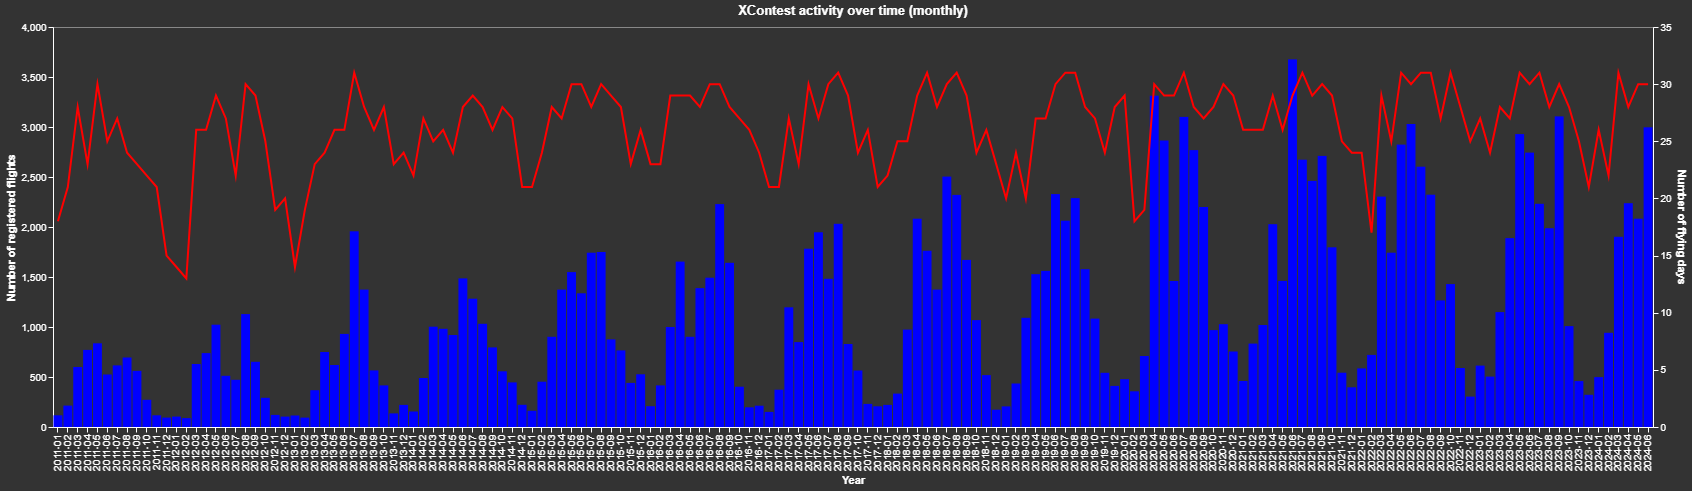

In [6]:
query = """
WITH flights AS (
    SELECT
        *,
        TO_CHAR(date, 'YYYY-MM') as month
    FROM source.flights
)
SELECT
    month,
    COUNT(*) AS total_flights,
    COUNT(DISTINCT date) AS flying_days
FROM flights
GROUP BY month
ORDER BY month
"""
df = pd.read_sql(query, engine)
base = alt.Chart(df).encode(
    x=alt.X('month:N', axis=alt.Axis(title='Year')),
    tooltip=['month:N', 'total_flights:Q', 'flying_days:Q']
)
bar = base.mark_bar(color='blue').encode(
    y=alt.Y('total_flights:Q', axis=alt.Axis(title='Number of registered flights'))
)
line1 = base.mark_line(color='red').encode(
    y=alt.Y('flying_days:Q', axis=alt.Axis(title='Number of flying days')),
).transform_calculate(
    var2='datum.flying_days'
)
combined = alt.layer(bar, line1).resolve_scale(
    y='independent'
).properties(
    width=1600,
    height=400,
    title="XContest activity over time (monthly)"
)
combined.show()